## Sentiment Classification: classifying IMDB reviews

In this task, you will learn how to process text data and how to train neural networks with limited input text data using pre-trained embeddings for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

We will use the `Embedding` layer in Keras to represent text input. The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, then looks up these integers into an internal dictionary, and finally returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have  shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

You can instantiate the `Embedding` layer by randomly initialising its weights (its internal dictionary of token vectors). During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for. You can also instantiate the `Embedding` layer by intialising its weights using the pre-trained word embeddings, such as GloVe word embeddings pretrained from Wikipedia articles.

#### a) Download the IMDB data as raw text

First, create a "data" directory, then head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Save it into the "data" directory. Uncompress it. Store the individual reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a separate `labels` list.

In [1]:
import os

# write your code here

'''
###############################################################################################################

NOTE: Please note that some comments were added after running, so they do not appear on the results section.
Comments are all in the code section.


################################################################################################################
'''


import numpy as np

'''
===========
LOAD FILES
===========
'''

# TRAINING SET

pos_dir = './aclImdb/train/pos/'
neg_dir = './aclImdb/train/neg/'

file_path = [pos_dir+i for i in os.listdir(pos_dir)]
file_path = file_path + [neg_dir+i for i in os.listdir(neg_dir)]

np.random.seed(1234) 
np.random.shuffle(file_path) # shuffles the ordering of filenames (deterministic given the chosen seed)

train_data = []
train_label = []

# loop over the reviews paths and get the labels
for reviewPath in file_path:
    
    if 'pos' in reviewPath:
        label = 1
    else:
        label = 0
        
    # load the reviews
    rev = open(reviewPath)
    # update the data and labels lists, respectively
    train_data.append(rev.read())
    rev.close()
    train_label.append(label)

In [2]:
# TESTING SET

pos_dir = './aclImdb/test/pos/'
neg_dir = './aclImdb/test/neg/'

file_path = [pos_dir+i for i in os.listdir(pos_dir)]
file_path = file_path + [neg_dir+i for i in os.listdir(neg_dir)]

np.random.shuffle(file_path) # shuffles the ordering of filenames (deterministic given the chosen seed)

test_data = []
test_label = []

# loop over the reviews paths and get the labels

for reviewPath in file_path:
    
    if 'pos' in reviewPath:
        label = 1
    else:
        label = 0
        
    # load the reviews
    rev = open(reviewPath)
    # update the data and labels lists, respectively
    test_data.append(rev.read())
    rev.close()
    test_label.append(label)

#### b) Pre-process the review documents 

Pre-process review documents by tokenisation and split the data into the training and testing sets. You can restrict the training data to the first 1000 reviews and only consider the top 5,000 words in the dataset. You can also cut reviews after 100 words (that is, each review contains a maximum of 100 words).

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# write your code here

train_data1 = []
train_label1 = []
test_data1 = []
test_label1 = []

for i in range(0,len(train_data),1):
    if len(train_data1) == 1000:
        break
    else:
        if len(train_data[i].split()) < 100:
            train_data1.append(train_data[i])
            train_label1.append(train_label[i])
            
test_label1 = test_label
test_data1 = test_data


'''
As suggested, we are only taking the first 1,000 reviews (which are already randomized) and restrinting 
them to the ones that contain a total of 100 words. This is to avoid cutting some of the positive or negative comments
and loose context.
'''


Using TensorFlow backend.


In [4]:
token_obj = Tokenizer(num_words=5000)
total_rev = train_data1 + test_data1
token_obj.fit_on_texts(total_rev)

# pad sequences
max_length = 100

train_tokens = token_obj.texts_to_sequences(train_data1)
test_tokens = token_obj.texts_to_sequences(test_data1)

train_pad = pad_sequences(train_tokens, maxlen=max_length, padding='post')
test_pad = pad_sequences(test_tokens, maxlen=max_length, padding='post')

'''
Now we tokenize our information which meand that every word is going to be mappeds into unique integer ids.
limiting to a total of 5,000 words. Then we follow to pad variable length sequences. The padding will be
performed on all sequences to achieve the max length of 100.
'''



#### c) Download the GloVe word embeddings and map each word in the dataset into its pre-trained GloVe word embedding.

First go to `https://nlp.stanford.edu/projects/glove/` and download the pre-trained 
embeddings from 2014 English Wikipedia into the "data" directory. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

Parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

Build an embedding matrix that will be loaded into an `Embedding` layer later. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [5]:
# write your code here

glove_path = './glove/glove.6B.100d.txt'

embeddings_index = {}

gf = open(glove_path)

for line in gf:
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    embeddings_index[word] = embedding

In [6]:


# recall that max_length = 100
embedding_dim = 100

embedding_matrix = np.zeros((5000, embedding_dim))
print(embedding_matrix.shape)
word_index = token_obj.word_index

for word, i in word_index.items():
    if i == 5000:
        break
    else:
        embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
'''
As our task is to predicting the polarity (positive or negative) of a review, we first need a model that can
precict the next word in a sentece. This is to undertand the lenguage structure, before it recognize weather
the comment has a positive or negative sentiment. As suggested, we are using pre-trained word representation
based on co-ocurrence probablitites.
'''

        

(5000, 100)


#### d) Build and train a simple Sequential model

The model contains an Embedding Layer with maximum number of tokens to be 10,000 and embedding dimensionality as 100. Initialise the Embedding Layer with the pre-trained GloVe word vectors. Set the maximum length of each review to 100. Flatten the 3D embedding output to 2D and add a Dense Layer which is the classifier. Train the model with a 'rmsprop' optimiser. You need to freeze the embedding layer by setting its `trainable` attribute to `False` so that its weights will not be updated during training.

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# write your code here


# recall that max_length = 100
# recall that embedding_dim = 100

model = Sequential()
model.add(Embedding(5000,100, weights=[embedding_matrix],
                    input_length=100,trainable=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

print(model.summary())

H = model.fit(train_pad, train_label1, epochs=10,
          validation_data=(test_pad, test_label1), verbose=2)


'''
Now we train a simple sequential model that contains an embeddign layer with our embedding matrix (the resultant of the
pre-trained GloVe word representation). In here now we expect to predict the sentiment (positive or negative) of our
reviews.
'''


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 510,001
Trainable params: 10,001
Non-trainable params: 500,000
_________________________________________________________________
None
Train on 1000 samples, validate on 25000 samples
Epoch 1/10
 - 1s - loss: 0.7763 - acc: 0.5370 - val_loss: 0.7426 - val_acc: 0.5510
Epoch 2/10
 - 0s - loss: 0.5476 - acc: 0.7120 - val_loss: 0.7396 - val_acc: 0.5696
Epoch 3/10
 - 0s - loss: 0.4227 - acc: 0.8300 - val_loss: 1.2834 - val_acc: 0.5110
Epoch 4/10
 - 0s - loss: 0.3517 - acc: 0.8870 - val_loss: 0.7107 - val_acc: 0.6000
Epoch 5/1

#### e) Plot the training and validation loss and accuracies and evaluate the trained model on the test set.

What do you observe from the results?

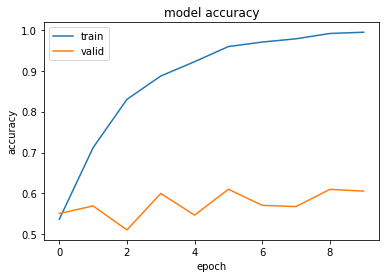

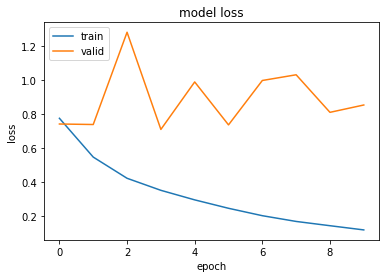

25000/25000 [==============================] - 1s 36us/step
Accuracy: 60.584


In [9]:
import matplotlib.pyplot as plt

# write your code here



# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

score = model.evaluate(test_pad, test_label1)
print('Accuracy: %s' % (score[1]*100))


'''
According to the graphs shown below, the accuracy of the training set is way higher than the validation set.
Also, the loss of our training set is considerably lower than the training set. The high difference in the performance
on both train and validation datasets reflects that our model is overfitting. The bad performance is consitently present
gets higher on every training step of the model. This model gets an accuracy of around 60.5% on the testing set.

'''


#### f) Add an LSTM layer into the simple neural network architecture and re-train the model on the training set, plot the training and validation loss/accuracies, also evaluate the trained model on the test set and report the result.

In [10]:
from keras.layers import LSTM

# write your code here


model = Sequential()
model.add(Embedding(5000,100, weights=[embedding_matrix],
                    input_length=100,trainable=False))
model.add(LSTM(100))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

print(model.summary())

H1 = model.fit(train_pad, train_label1, epochs=10,
          validation_data=(test_pad, test_label1), verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               25250     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 605,901
Trainable params: 105,901
Non-trainable params: 500,000
_________________________________________________________________
None
Train on 1000 samples, validate on 25000 samples
Epoch 1/10
 - 28s - loss: 0.6934 - acc: 0.5210 - val_loss: 0.9575 - val_acc: 0.5005
Epoch 2/10
 - 27s - loss: 0.6906 - acc: 0.5420 - val_loss: 0.7046 - val_acc: 0.5180
Epoch 3/10
 - 27s - loss: 0.6881 - acc: 

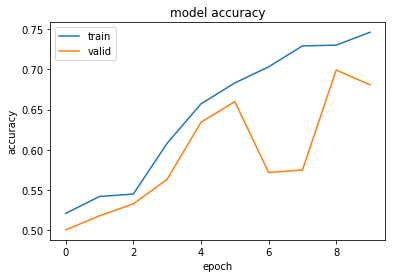

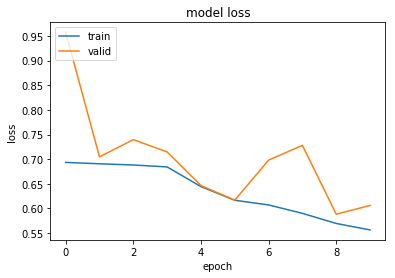

25000/25000 [==============================] - 24s 945us/step
Accuracy: 68.068


In [11]:

# summarize history for accuracy
plt.plot(H1.history['acc'])
plt.plot(H1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(H1.history['loss'])
plt.plot(H1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

score = model.evaluate(test_pad, test_label1)

print('Accuracy: %s' % (score[1]*100))


'''
By implementing an LSTME layer we can observe a better performance. The accuracy of our model reduced the
over-learning on the trainig dataset, given that now the validation accuracy is closer to the training result. Also, 
now we can see that the model presents a more comparable loss performance on both train and validation datasets.
Finally, we obtained a significant improvement on the accuracy level, confirming that this model
has a better performance.
'''
